# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# Define the ODE to solve 

We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ y'=(1-\dfrac{y}{C})r-d\exp(-g t)y$$

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-

In [2]:
#Here we defien the ODE model
def ode_model(contamination,t,r,C,d,g):
    Contamination = contamination;
    return(r*(1-Contamination/C)-d*math.exp(-g*t)*Contamination)

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [3]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 200.0),
                               C=RV("uniform", 1000.0, 6000.0),
                               d=RV("uniform", 10.0, 1000.0),
                               g=RV("uniform", 2.0, 200.0))

parameter_prior.get_parameter_names()

['C', 'd', 'g', 'r']

# Define the distance fuction
This currently is a vanilla absolute distances between the two points.

In [4]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()

# Set up the ABC SMC 


In [5]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [6]:
# We plug all the ABC options together
abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=500,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(50, median_multiplier=0.7),
)

INFO:Sampler:Parallelizing the sampling on 8 cores.


# Setting the observed data

In [7]:
# y_observed is the important piece here: our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0]) #,400,644,1232,2044,2868
s=np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556])
precision=5000
measurement_times = np.array([2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

history = abc.new(db_path, {"Contamination": measurement_data,"sd":s})

INFO:History:Start <ABCSMC(id=5, start_time=2022-04-07 13:42:13.418904, end_time=None)>


# Running the ABC

In [8]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=1, max_nr_populations=5)

INFO:ABC:t: 0, eps: 50.
INFO:ABC:Acceptance rate: 500 / 565 = 8.8496e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 11.774685378941664.
INFO:ABC:Acceptance rate: 500 / 1738 = 2.8769e-01, ESS=4.2295e+02.
INFO:ABC:t: 2, eps: 5.523131592391039.
INFO:ABC:Acceptance rate: 500 / 18431 = 2.7128e-02, ESS=4.1775e+02.
INFO:ABC:t: 3, eps: 3.4899717157985934.


KeyboardInterrupt: 

# Visualisations of Variables
Simulated trajectories plotted against observed experimental data

NameError: name 'h' is not defined

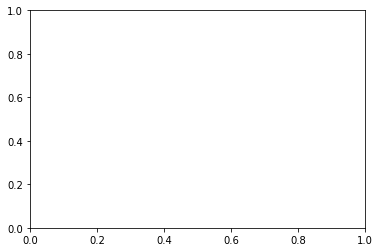

# Visualise the probability density functions


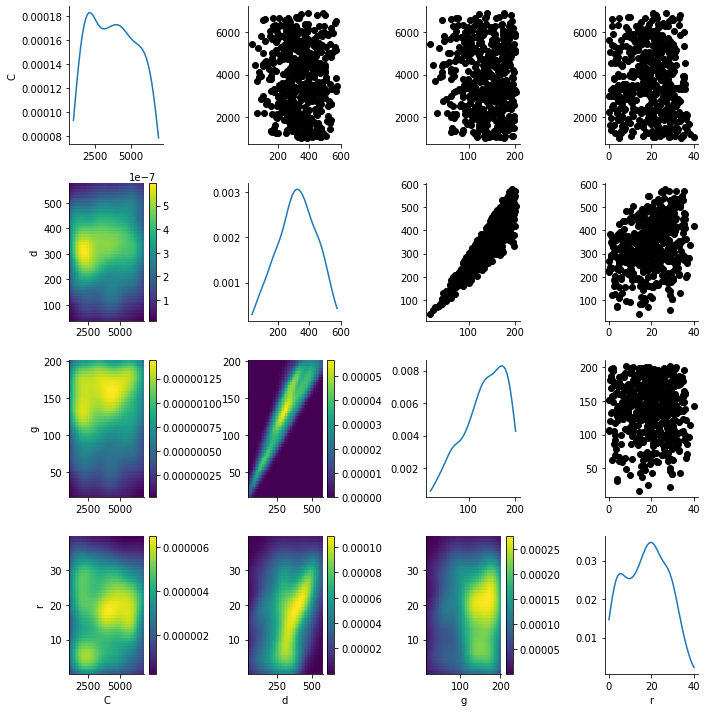

In [49]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

AttributeError: 'Line2D' object has no property 'xname'

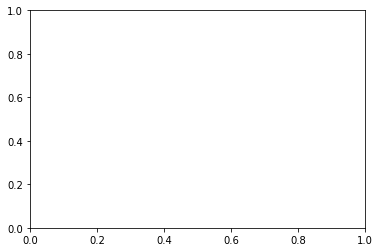

In [50]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=40,
        x="r",
        xname=r"$r$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(20, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [ ]:
df.to_csv("../Data/abc_results.csv", encoding='utf-8', index=False)
df.describe()

,Unnamed: 0,conc,time,id
count,90.000000,90.000000,90.000000,90.000000
mean,45.500000,66569.888889,12.444444,5.777778
std,26.124701,107527.151037,8.882644,2.874834
min,1.000000,40.000000,0.000000,1.000000
25%,23.250000,655.000000,4.000000,3.000000
50%,45.500000,8620.000000,16.000000,6.000000
75%,67.750000,75600.000000,20.000000,8.000000
max,90.000000,548000.000000,24.000000,10.000000


# Plot some trajectories


ValueError: Input passed into argument "'y1'"is not 1-dimensional.

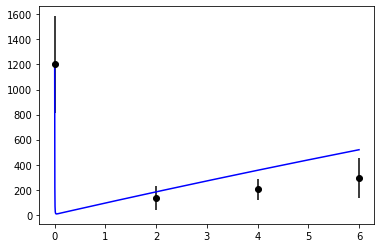

In [55]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 6
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.05),df["C"].quantile(0.05),df["d"].quantile(0.05),df["g"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.95),df["C"].quantile(0.95),df["d"].quantile(0.95),df["g"].quantile(0.95)))

#P=ode_model({"af":df["af"].mean(),"cs":df["cs"].mean(),"lam":df["lam"].mean()})
#Pmin=ode_model({"af":df["af"].quantile(0.05),"cs":df["cs"].quantile(0.05),"lam":df["lam"].quantile(0.05)})
#Pmax=ode_model({"af":df["af"].quantile(0.95),"cs":df["cs"].quantile(0.95),"lam":df["lam"].quantile(0.95)})

# create a vector of values between 0 and 6
x = np.array([0,2,4,6])

#Define new sd just for plotting to avoid SD value at 0
s=np.array([385,93.70165,86.13942,162.11107])
measurement_data = np.array([1200,134.0,202.0,294.0])

#Plot errobars of experimental data
x = np.array([0,2,4,6])
plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction
plt.fill_between(x,Pmin,Pmax,alpha=0.2,color='blue')



#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,8)
plt.ylabel("CUF recovered from finger \n after t hours")
plt.xlabel("Number of contacts")
plt.legend(loc="upper left")


#save the plot
#plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()

In [ ]:
#print the shape of time_space
print(odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean(),df["d"].mean(),df["g"].mean())))

[[1200.        ]
 [ 632.15136867]
 [ 358.45920492]
 ...
 [ 519.03566515]
 [ 519.1317946 ]
 [ 519.22792128]]
